### Outline:
    1. GCN model with dropout()
    2. GCN model with dropEdges
    3. GCN model with dropNodes
    4. JKNet model
    5. DeeperGCN model
    6. GCNII model
    7. PairNorm: Tackling Oversmoothing in GNNs

# Dataset

In [76]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="cora")

data = dataset[0]


### Data Analysis

In [77]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [78]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 0


# Plot dataset

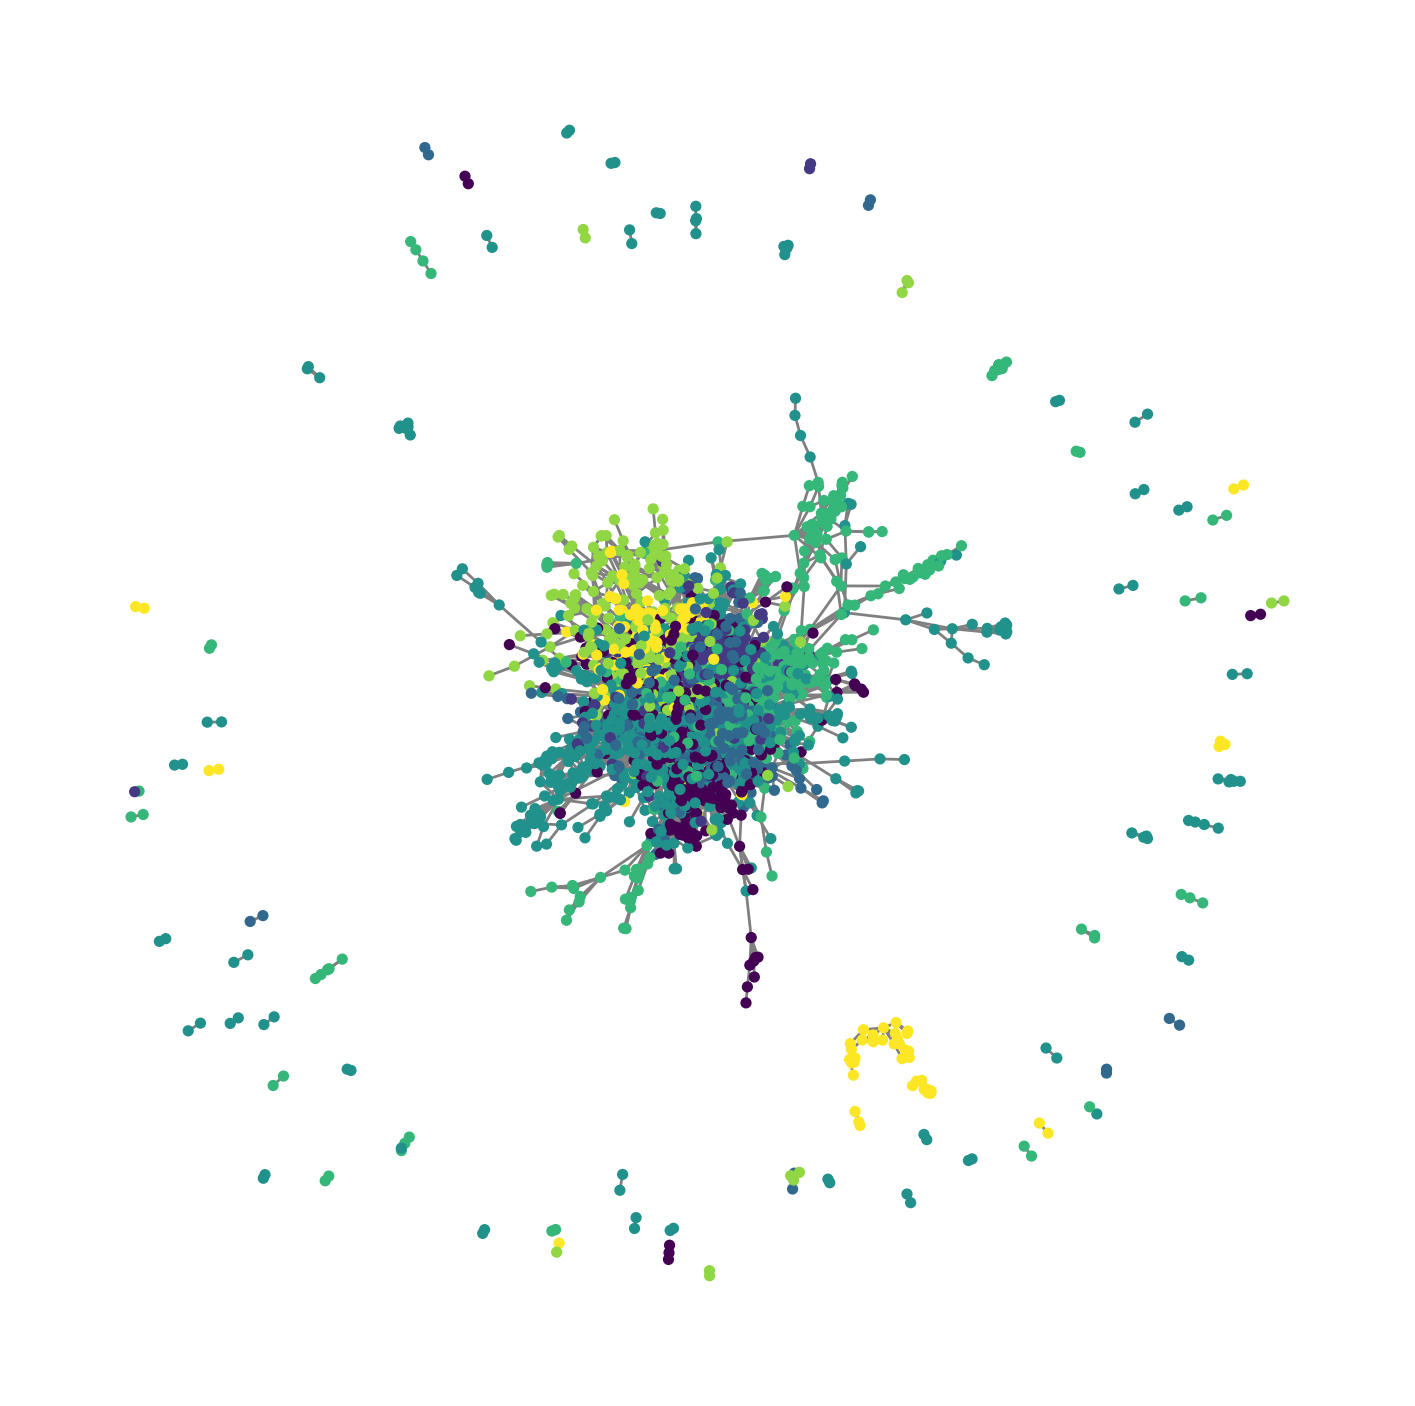

In [79]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

# Plot node degrees

<BarContainer object of 37 artists>

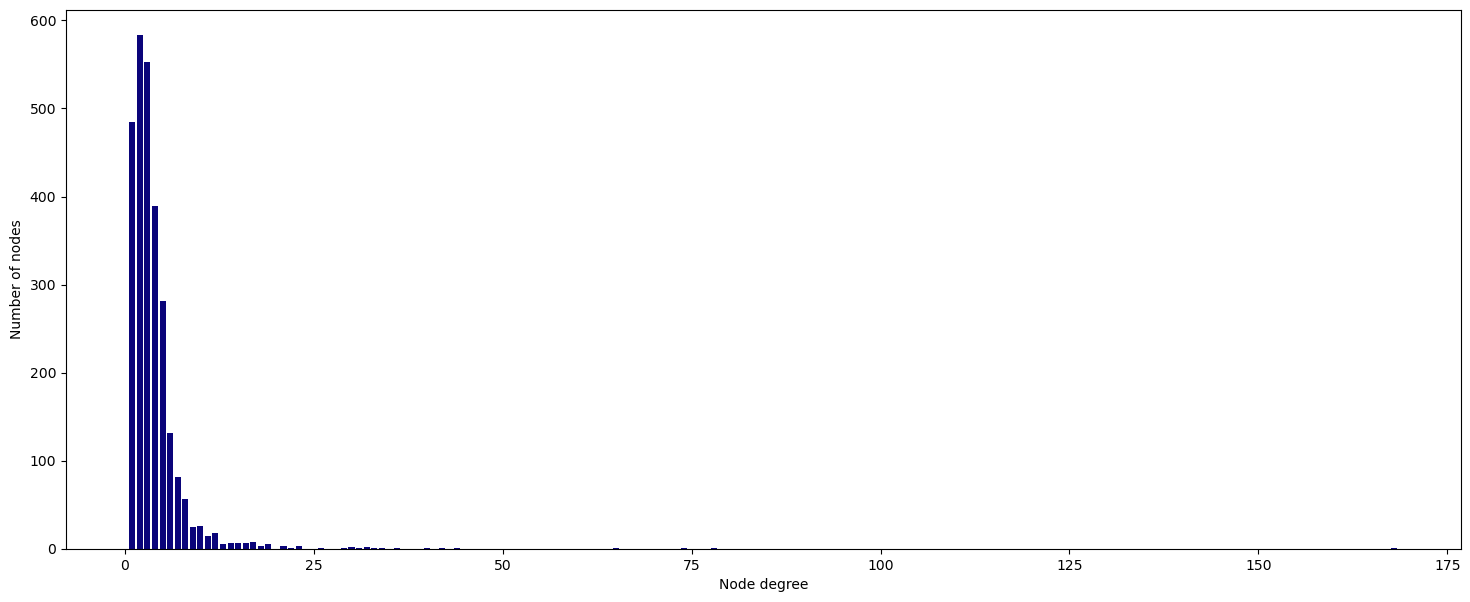

In [80]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

# 1. GCN with dropout()

## 1.1. GCN model with dropout()

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, X, A):
        # Multiply adjacency matrix A with X
        AX = torch.matmul(A, X)
        # Apply linear transformation
        output = self.linear(AX)
        return output

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, output_dim)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01, 
                                          weight_decay=5e-4)

    def forward(self, X, A):
        # First GCN layer with dropout and relu
        h = F.dropout(X, p=0.5, training=self.training)
        h = self.gcn1(h, A)
        h = F.relu(h)
        # Second GCN layer with dropout
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, A)
        # Apply log softmax
        return h, F.log_softmax(h, dim=1)


## 1.2. Convert Edge Index to Adjacency Matrix

In [82]:
def edge_index_to_adj(edge_index, num_nodes):
    A = torch.zeros((num_nodes, num_nodes))
    A[edge_index[0], edge_index[1]] = 1
    return A

## 1.3. Train function

In [83]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data, A):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 5

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, A)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every epoch
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
              f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
              f'Val Acc: {val_acc*100:.2f}%')

    return model

## 1.4. Test function 

In [84]:
def test(model, data, A):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, A)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

## 1.5. Training

In [85]:
%%time

A = edge_index_to_adj(data.edge_index, num_nodes)

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data, A)

# Test
acc = test(gcn, data, A)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)
Epoch   0 | Train Loss: 2.131 | Train Acc:  15.71% | Val Loss: 2.03 | Val Acc: 15.20%
Epoch   1 | Train Loss: 3.771 | Train Acc:  25.71% | Val Loss: 3.64 | Val Acc: 21.60%
Epoch   2 | Train Loss: 1.501 | Train Acc:  47.86% | Val Loss: 1.63 | Val Acc: 50.60%
Epoch   3 | Train Loss: 1.514 | Train Acc:  49.29% | Val Loss: 1.66 | Val Acc: 42.20%
Epoch   4 | Train Loss: 1.533 | Train Acc:  42.86% | Val Loss: 1.63 | Val Acc: 43.40%
Epoch   5 | Train Loss: 1.500 | Train Acc:  52.14% | Val Loss: 1.64 | Val Acc: 47.60%

GCN test accuracy: 54.00%

CPU times: user 3.25 s, sys: 29.7 ms, total: 3.28 s
Wall time: 139 ms


# 2. GCN with dropEdges

## 2.1. GCN layer

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # GCN aggregation
        h = torch.mm(adj, x)
        h = self.linear(h)
        return h


## 2.2. Drop Edge

In [35]:
def drop_edges(adj, drop_prob):
    """Randomly drop edges from the adjacency matrix."""
    mask = (torch.rand(adj.shape) > drop_prob).float()
    dropped_adj = adj * mask
    return dropped_adj


## 2.3. GCN with DropEdge

In [36]:
class GCN_dropEdges(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GCN_dropEdges, self).__init__()
        self.gcn1 = GCNLayer(in_features, hidden_features)
        self.gcn2 = GCNLayer(hidden_features, out_features)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, adj):
        # First GCN layer with dropout
        x = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(x, adj)
        h = F.relu(h)
        
        # Second GCN layer with dropout
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, adj)
        
        # Return intermediate representation and log softmax for classification
        return h, F.log_softmax(h, dim=1)


## 2.4. Training

In [37]:
def train_dropEdges(model, data, adj, epochs=5, drop_prob=0.5):
    """Train GCN with edge dropout."""
    criterion = nn.CrossEntropyLoss()
    optimizer = model.optimizer

    for epoch in range(epochs + 1):
        model.train()
        optimizer.zero_grad()
        
        # Apply edge dropout
        adj_dropped = drop_edges(adj, drop_prob)
        
        # Forward pass
        _,output = model(data.x, adj_dropped)
        
        # Calculate loss
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accuracy and validation
        train_acc = accuracy(output[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        val_loss = criterion(output[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(output[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        
        if epoch % 1 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{train_acc*100:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')


## 2.5. Test

In [38]:
def test(model, data, adj):
    """Evaluate the model on the test set and return accuracy."""
    model.eval()
    with torch.no_grad():  # No need to compute gradients during testing
        _, out = model(data.x, adj)  # Now expecting two values
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc


## 2.6. Convert edge_index to adjacency matrix

In [39]:
import torch
from torch_geometric.utils import to_dense_adj

# Convert edge_index to dense adjacency matrix
adj = to_dense_adj(data.edge_index)[0]  # Get the adjacency matrix (remove batch dimension)

print(adj.shape)  # Should be (number of nodes, number of nodes)


torch.Size([2708, 2708])


In [40]:
%%time

# Create GCN model
gcn = GCN_dropEdges(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train the model with edge dropout
train_dropEdges(gcn, data, adj)

# Test the model
acc = test(gcn, data, adj)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')


GCN_dropEdges(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)
Epoch   0 | Train Loss: 1.985 | Train Acc: 12.14% | Val Loss: 1.94 | Val Acc: 16.00%
Epoch   1 | Train Loss: 1.952 | Train Acc: 20.00% | Val Loss: 1.99 | Val Acc: 18.80%
Epoch   2 | Train Loss: 1.686 | Train Acc: 32.14% | Val Loss: 1.80 | Val Acc: 30.40%
Epoch   3 | Train Loss: 1.742 | Train Acc: 38.57% | Val Loss: 1.77 | Val Acc: 35.80%
Epoch   4 | Train Loss: 1.669 | Train Acc: 47.86% | Val Loss: 1.74 | Val Acc: 35.80%
Epoch   5 | Train Loss: 1.504 | Train Acc: 40.71% | Val Loss: 1.72 | Val Acc: 36.00%

GCN test accuracy: 62.00%

CPU times: user 4.64 s, sys: 176 ms, total: 4.81 s
Wall time: 285 ms


# 3. GCN with DropNodes

## 3.1. Dropout Node

In [41]:
def dropout_node(x, edge_index, y, train_mask, val_mask, test_mask, drop_prob=0.5):
    """
    Randomly drop nodes (and their corresponding edges) from the graph and adjust the labels and masks.

    Parameters:
    x (torch.Tensor): Node features.
    edge_index (torch.Tensor): Edge list in COO format.
    y (torch.Tensor): Node labels.
    train_mask, val_mask, test_mask (torch.Tensor): Masks for training, validation, and testing.
    drop_prob (float): Dropout probability for nodes.

    Returns:
    new_x (torch.Tensor): Node features after dropout.
    new_edge_index (torch.Tensor): Updated edge list after removing edges of dropped nodes.
    new_y (torch.Tensor): Updated node labels after dropout.
    new_train_mask, new_val_mask, new_test_mask (torch.Tensor): Updated masks after node dropout.
    """
    num_nodes = x.size(0)
    
    # Create a mask that decides which nodes to keep (True means keep, False means drop)
    keep_mask = (torch.rand(num_nodes) > drop_prob).bool()
    
    # Keep only the node features that are not dropped
    new_x = x[keep_mask]
    
    # Now we need to remap the node indices for the remaining nodes.
    # Create a mapping from old node indices to new node indices
    node_idx = torch.arange(num_nodes)
    mapping = torch.zeros(num_nodes, dtype=torch.long)
    mapping[keep_mask] = torch.arange(keep_mask.sum())
    
    # Keep only the edges that connect to kept nodes
    edge_mask = keep_mask[edge_index[0]] & keep_mask[edge_index[1]]
    new_edge_index = edge_index[:, edge_mask]
    
    # Remap the indices in new_edge_index based on the mapping
    new_edge_index = mapping[new_edge_index]
    
    # Adjust the train_mask, val_mask, and test_mask to account for the dropped nodes
    new_train_mask = train_mask[keep_mask]
    new_val_mask = val_mask[keep_mask]
    new_test_mask = test_mask[keep_mask]
    
    # Adjust the labels to only keep the labels for the remaining nodes
    new_y = y[keep_mask]
    
    return new_x, new_edge_index, new_y, new_train_mask, new_val_mask, new_test_mask


## 3.2. GCN layer

In [42]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, edge_index):
        # Apply the graph convolution operation
        row, col = edge_index
        deg = torch.bincount(row)  # Compute the degree of each node
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        # Perform the aggregation
        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col] * norm.unsqueeze(1))
        return self.linear(out)


## 3.3. GCN with Drop Node

In [43]:
class GCN_dropNodes(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GCN_dropNodes, self).__init__()
        self.gcn1 = GCNLayer(in_features, hidden_features)
        self.gcn2 = GCNLayer(hidden_features, out_features)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, edge_index):
        # First GCN layer with dropout
        x = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(x, edge_index)
        h = F.relu(h)
        
        # Second GCN layer with dropout
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        
        # Return intermediate representation and log softmax for classification
        return h, F.log_softmax(h, dim=1)

## 3.4. Training

In [44]:
def train_dropNodes(model, data, epochs=5, drop_prob=0.5):
    """Train a GCN model with node dropout and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        
        # Apply node dropout
        new_x, new_edge_index, new_y, new_train_mask, new_val_mask, new_test_mask = dropout_node(
            data.x, data.edge_index, data.y, data.train_mask, data.val_mask, data.test_mask, drop_prob=drop_prob)
        
        # Forward pass
        _, out = model(new_x, new_edge_index)
        
        # Calculate the loss and accuracy
        loss = criterion(out[new_train_mask], new_y[new_train_mask])
        acc = accuracy(out[new_train_mask].argmax(dim=1), new_y[new_train_mask])
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Validation step
        val_loss = criterion(out[new_val_mask], new_y[new_val_mask])
        val_acc = accuracy(out[new_val_mask].argmax(dim=1), new_y[new_val_mask])

        # Print metrics every epoch
        if epoch % 1 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    return model


## 3.5. Testing

In [45]:
def test(model, data):
    """Evaluate the model on the test set."""
    model.eval()
    with torch.no_grad():
        _, out = model(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [46]:
%%time

# Create GCN model
gcn = GCN_dropNodes(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train the model with node dropout
train_dropNodes(gcn, data)

# Test the model
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')


GCN_dropNodes(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)
Epoch   0 | Train Loss: 1.960 | Train Acc: 12.68% | Val Loss: 1.95 | Val Acc: 14.50%
Epoch   1 | Train Loss: 1.952 | Train Acc: 20.00% | Val Loss: 1.94 | Val Acc: 19.92%
Epoch   2 | Train Loss: 1.892 | Train Acc: 30.14% | Val Loss: 1.93 | Val Acc: 26.05%
Epoch   3 | Train Loss: 1.905 | Train Acc: 28.99% | Val Loss: 1.90 | Val Acc: 30.38%
Epoch   4 | Train Loss: 1.857 | Train Acc: 28.75% | Val Loss: 1.88 | Val Acc: 33.70%
Epoch   5 | Train Loss: 1.811 | Train Acc: 32.84% | Val Loss: 1.86 | Val Acc: 33.20%

GCN test accuracy: 42.00%

CPU times: user 1.07 s, sys: 86.8 ms, total: 1.15 s
Wall time: 52.2 ms


# 4. JKNet (Jumping Knowledge) 

In [49]:
# Extract features, labels, edge index, and masks
x = data.x  # Node features (size [2708, 1433])
y = data.y  # Labels (size [2708])
edge_index = data.edge_index  # Edge index (size [2, number of edges])

train_mask = data.train_mask  # Training mask
val_mask = data.val_mask  # Validation mask
test_mask = data.test_mask  # Test mask


In [50]:
def create_adjacency_matrix(edge_index, num_nodes):
    """Create an adjacency matrix from the edge_index."""
    adj = torch.zeros((num_nodes, num_nodes))
    adj[edge_index[0], edge_index[1]] = 1
    adj[edge_index[1], edge_index[0]] = 1  # Symmetric for undirected graph
    return adj

# Create adjacency matrix
adj = create_adjacency_matrix(edge_index, x.size(0))

# Print the shape of the adjacency matrix
print(f"Adjacency matrix shape: {adj.shape}")

Adjacency matrix shape: torch.Size([2708, 2708])


## 4.2. Jumping Knowledge

In [51]:
class JumpingKnowledge(nn.Module):
    def __init__(self, mode='max'):
        super(JumpingKnowledge, self).__init__()
        self.mode = mode

    def forward(self, layer_out):
        if self.mode == 'max':
            return torch.max(torch.stack(layer_out, dim=0), dim=0)[0]  # Max-pooling over layers
        elif self.mode == 'cat':
            return torch.cat(layer_out, dim=1)  # Concatenate outputs

## 4.3. GCN layer

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # Apply GCN formula: A_hat * X * W
        h = torch.mm(adj, x)
        h = self.linear(h)
        return h


## 4.4. JKNet

In [53]:
class JKNet(nn.Module):
    def __init__(self, in_features, hidden, out_features, num_layers=6, mode='max'):
        super(JKNet, self).__init__()
        self.num_layers = num_layers
        self.mode = mode

        # Define the first GCN layer
        self.conv0 = GCNLayer(in_features, hidden)
        self.dropout0 = nn.Dropout(p=0.5)

        # Define additional GCN layers
        for i in range(1, num_layers):
            setattr(self, 'conv{}'.format(i), GCNLayer(hidden, hidden))
            setattr(self, 'dropout{}'.format(i), nn.Dropout(p=0.5))

        # Jumping Knowledge layer
        self.jk = JumpingKnowledge(mode=mode)
        
        # Final fully connected layer
        if mode == 'max':
            self.fc = nn.Linear(hidden, out_features)
        elif mode == 'cat':
            self.fc = nn.Linear(num_layers * hidden, out_features)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, adj):
        layer_out = []  # To store outputs from all layers

        # Forward pass through each GCN layer
        for i in range(self.num_layers):
            conv = getattr(self, 'conv{}'.format(i))
            dropout = getattr(self, 'dropout{}'.format(i))
            x = dropout(F.relu(conv(x, adj)))
            layer_out.append(x)

        # Apply Jumping Knowledge aggregation
        h = self.jk(layer_out)
        
        # Final fully connected layer
        h = self.fc(h)
        return h, F.log_softmax(h, dim=1)


## 4.5. Training

In [54]:
def train(model, x, adj, y, train_mask, val_mask, epochs=200):
    """Train the JKNet model."""
    criterion = nn.CrossEntropyLoss()
    optimizer = model.optimizer
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        _, out = model(x, adj)
        
        # Loss calculation and backpropagation
        loss = criterion(out[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()

        # Validation (optional)
        val_loss = criterion(out[val_mask], y[val_mask])
        val_acc = accuracy(out[val_mask].argmax(dim=1), y[val_mask])

        if epoch % 10 == 0:
            print(f"Epoch {epoch:>3} | Loss: {loss:.3f} | Val Acc: {val_acc*100:.2f}%")




## 4.6. Testing

In [55]:
def test(model, x, adj, y, test_mask):
    """Evaluate the JKNet model."""
    model.eval()
    with torch.no_grad():
        _, out = model(x, adj)
        acc = accuracy(out[test_mask].argmax(dim=1), y[test_mask])
    return acc


## 4.7. Accuracy

In [56]:
def accuracy(preds, labels):
    """Calculate accuracy."""
    return (preds == labels).sum().item() / labels.size(0)

# Create adjacency matrix for Cora dataset
adj = create_adjacency_matrix(data.edge_index, x.size(0))

In [57]:
# Initialize the JKNet model
jkGCN = JKNet(in_features=x.shape[1], hidden=16, out_features=dataset.num_classes, num_layers=6, mode='max')
print(jkGCN)

# Train the model
train(jkGCN, x, adj, y, train_mask, val_mask)

# Test the model
acc = test(jkGCN, x, adj, y, test_mask)
print(f"\nTest accuracy: {acc*100:.2f}%\n")

JKNet(
  (conv0): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (dropout0): Dropout(p=0.5, inplace=False)
  (conv1): GCNLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): GCNLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): GCNLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): GCNLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (dropout4): Dropout(p=0.5, inplace=False)
  (conv5): GCNLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (dropout5): Dropout(p=0.5, inplace=False)
  (jk): JumpingKnowledge()
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Epoch   0 | Loss: 145.546 | Val Acc: 22.80%
Epoch  10 | Loss: 2.988 | Val Acc: 20.00%
Epoch  20 | Lo

# 5. DeeperGCN

In [58]:
# Load the Cora dataset from torch_geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Prepare the data (converting edge_index to a dense adjacency matrix for non-torch_geometric use)
num_nodes = data.x.shape[0]
num_features = data.num_features
num_classes = dataset.num_classes
adj = torch.zeros((num_nodes, num_nodes))
adj[data.edge_index[0], data.edge_index[1]] = 1  # Create adjacency matrix from edge_index


## 5.1. GENConv

In [59]:
from torch.nn import Linear, LayerNorm, ReLU

class GENConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, aggr='softmax', t=1.0, learn_t=True, num_layers=2, norm='layer'):
        super(GENConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.aggr = aggr
        self.num_layers = num_layers
        self.norm = LayerNorm(in_channels) if norm == 'layer' else None
        self.t = torch.nn.Parameter(torch.Tensor([t])) if learn_t else t

        self.lin = Linear(in_channels, out_channels)
        self.mlp = torch.nn.Sequential(
            Linear(in_channels, out_channels),
            ReLU(inplace=True),
            Linear(out_channels, out_channels)
        )
        
    def forward(self, x, adj):
        # Message passing using adjacency matrix
        if self.aggr == 'softmax':
            row_sum = adj.sum(dim=-1, keepdim=True)
            adj = adj / row_sum.clamp(min=1e-16)
        x = torch.matmul(adj, x)
        return self.mlp(self.lin(x))


## 5.2. DeepGCNLayer

In [60]:
class DeepGCNLayer(torch.nn.Module):
    def __init__(self, conv, norm, act, block='res+', dropout=0.1, ckpt_grad=False):
        super(DeepGCNLayer, self).__init__()
        self.conv = conv
        self.norm = norm
        self.act = act
        self.block = block
        self.dropout = dropout
        self.ckpt_grad = ckpt_grad

    def forward(self, x, adj):
        h = x
        x = self.conv(x, adj)
        x = self.norm(x)
        x = self.act(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Residual block
        if self.block == 'res+':
            x = x + h
        return x

## 5.3. DeeperGCN

In [61]:
class DeeperGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, dim=16, num_layers=2, drop=0.5):
        super(DeeperGCN, self).__init__()

        self.node_encoder = Linear(num_features, dim)
        self.h = None
        self.layers = torch.nn.ModuleList()
        
        for i in range(1, num_layers + 1):
            conv = GENConv(dim, dim, aggr='softmax', t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = LayerNorm(dim, elementwise_affine=True)
            act = ReLU(inplace=True)

            layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.1, ckpt_grad=i % 3)
            self.layers.append(layer)
            
        self.mlp = Linear(dim, num_classes)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, adj):
        x = self.node_encoder(x)
        x = self.layers[0].conv(x, adj)

        for layer in self.layers[1:]:
            x = layer(x, adj)

        x = self.layers[0].act(self.layers[0].norm(x))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.mlp(x)
        self.h = x
        return x, F.log_softmax(x, dim=1)

## 5.4 Train and test

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move data to the device
data.x = data.x.to(device)
data.y = data.y.to(device)
adj = adj.to(device)

model = DeeperGCN(num_features=num_features, num_classes=num_classes, dim=16, num_layers=2, drop=0.5).to(device)
optimizer = model.optimizer

def train():
    model.train()
    optimizer.zero_grad()
    out, log_probs = model(data.x, adj)
    loss = F.nll_loss(log_probs[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    _, log_probs = model(data.x, adj)
    pred = log_probs.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())
    return acc

# Train for 200 epochs
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 10, Loss: 1.5204, Test Accuracy: 0.4440
Epoch: 20, Loss: 0.9484, Test Accuracy: 0.6450
Epoch: 30, Loss: 0.4733, Test Accuracy: 0.6860
Epoch: 40, Loss: 0.2116, Test Accuracy: 0.6820
Epoch: 50, Loss: 0.1401, Test Accuracy: 0.6650
Epoch: 60, Loss: 0.0968, Test Accuracy: 0.6530
Epoch: 70, Loss: 0.0555, Test Accuracy: 0.6480
Epoch: 80, Loss: 0.0306, Test Accuracy: 0.6640
Epoch: 90, Loss: 0.0514, Test Accuracy: 0.6630
Epoch: 100, Loss: 0.0232, Test Accuracy: 0.6580
Epoch: 110, Loss: 0.0207, Test Accuracy: 0.6460
Epoch: 120, Loss: 0.0140, Test Accuracy: 0.6780
Epoch: 130, Loss: 0.0164, Test Accuracy: 0.6390
Epoch: 140, Loss: 0.0479, Test Accuracy: 0.6590
Epoch: 150, Loss: 0.0131, Test Accuracy: 0.6550
Epoch: 160, Loss: 0.0566, Test Accuracy: 0.6660
Epoch: 170, Loss: 0.0166, Test Accuracy: 0.6710
Epoch: 180, Loss: 0.0205, Test Accuracy: 0.6620
Epoch: 190, Loss: 0.0097, Test Accuracy: 0.6570
Epoch: 200, Loss: 0.0126, Test Accuracy: 0.6720


# 6. GCNII 

## 6.1. GCN2Conv

In [63]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

class GCN2Conv(torch.nn.Module):
    def __init__(self, channels, alpha, theta, layer, shared_weights=True, normalize=False):
        super(GCN2Conv, self).__init__()
        self.channels = channels
        self.alpha = alpha
        self.theta = theta
        self.layer = layer
        self.shared_weights = shared_weights

        # Linear transformations for the convolution
        self.linear = Linear(channels, channels)

        # Optional shared weights between layers
        if not shared_weights:
            self.linear_residual = Linear(channels, channels)

    def forward(self, x, x_0, adj):
        # Perform GCNII propagation

        # Normalize adjacency matrix
        adj_norm = self.normalize_adj(adj)

        # Compute (1 - alpha) * A_norm * X + alpha * X_0
        out = (1 - self.alpha) * torch.mm(adj_norm, x) + self.alpha * x_0

        # Apply linear transformation
        out = F.relu(self.theta * out + (1 - self.theta) * F.relu(torch.mm(adj_norm, F.relu(out))))
        
        return out

    def normalize_adj(self, adj):
        # Normalize adjacency matrix
        rowsum = torch.sum(adj, dim=1)
        d_inv_sqrt = torch.pow(rowsum, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = torch.diag(d_inv_sqrt)
        return torch.mm(torch.mm(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)

## 6.2. GCNII model

In [64]:
class GCNII(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=16, num_layers=2, shared_weights=True, dropout=0.0):
        super(GCNII, self).__init__()

        # Define layers
        self.proj = Linear(1, 64)
        self.lins1 = Linear(num_features, hidden_channels)
        self.lins2 = Linear(hidden_channels, num_classes)

        # Custom GCN2Conv layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(
                GCN2Conv(hidden_channels, 0.1, 0.5, layer + 1, shared_weights)
            )

        # Dropout and optimizer
        self.dropout = dropout
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, edge_index):
        # Convert sparse edge_index to dense adjacency matrix
        adj = to_dense_adj(edge_index)[0]

        # Apply dropout to input features
        x = F.dropout(x, self.dropout, training=self.training)

        # First layer transformation
        x = self.lins1(x)
        x_0 = x.relu()  # Store the initial hidden representation x_0

        # Apply custom GCN2Conv layers
        for conv in self.convs:
            x = F.dropout(x, self.dropout, training=self.training)
            x = conv(x, x_0, adj)

        # Final layer transformation
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lins2(x)
        return x, F.log_softmax(x, dim=-1)

## 6.3. Training

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Accuracy function
def accuracy(output, labels, mask):
    preds = output[mask].max(1)[1]
    correct = preds.eq(labels[mask]).sum().item()
    return correct / mask.sum().item()

# Training loop
def train(model, optimizer, data, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Move data to the same device as the model
        data_x = data.x.to(device)
        data_edge_index = data.edge_index.to(device)
        data_y = data.y.to(device)
        train_mask = data.train_mask.to(device)
        test_mask = data.test_mask.to(device)

        # Forward pass
        _, output = model(data_x, data_edge_index)

        # Compute loss
        loss = F.nll_loss(output[train_mask], data_y[train_mask])
        loss.backward()

        # Optimizer step
        optimizer.step()

        if epoch % 10 == 0:
            acc = accuracy(output, data_y, test_mask)
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

# Main execution
model = GCNII(num_features=dataset.num_node_features, num_classes=dataset.num_classes, hidden_channels=16, num_layers=2, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Train the model on GPU
train(model, optimizer, data)

Epoch 0, Loss: 1.9450, Accuracy: 0.1650
Epoch 10, Loss: 1.4400, Accuracy: 0.4180
Epoch 20, Loss: 1.0357, Accuracy: 0.5170
Epoch 30, Loss: 0.7444, Accuracy: 0.5920
Epoch 40, Loss: 0.7154, Accuracy: 0.5900
Epoch 50, Loss: 0.6003, Accuracy: 0.6030
Epoch 60, Loss: 0.6369, Accuracy: 0.6210
Epoch 70, Loss: 0.5246, Accuracy: 0.6030
Epoch 80, Loss: 0.5063, Accuracy: 0.6350
Epoch 90, Loss: 0.4864, Accuracy: 0.6290
Epoch 100, Loss: 0.4660, Accuracy: 0.6000
Epoch 110, Loss: 0.4336, Accuracy: 0.6090
Epoch 120, Loss: 0.4302, Accuracy: 0.6160
Epoch 130, Loss: 0.4119, Accuracy: 0.6430
Epoch 140, Loss: 0.3357, Accuracy: 0.6470
Epoch 150, Loss: 0.3726, Accuracy: 0.6030
Epoch 160, Loss: 0.3965, Accuracy: 0.6430
Epoch 170, Loss: 0.3781, Accuracy: 0.6220
Epoch 180, Loss: 0.4405, Accuracy: 0.6480
Epoch 190, Loss: 0.3425, Accuracy: 0.6290


## 6.4. Test

In [66]:
def test(model, data):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for testing
        data_x = data.x.to(device)
        data_edge_index = data.edge_index.to(device)
        data_y = data.y.to(device)
        test_mask = data.test_mask.to(device)

        # Forward pass
        _, output = model(data_x, data_edge_index)

        # Compute accuracy on the test set
        acc = accuracy(output, data_y, test_mask)
        print(f"Test Accuracy: {acc:.4f}")

# Test the model
test(model, data)

Test Accuracy: 0.7840


# 7. PairNorm

## 7.1. PairNorm

In [10]:
import torch.nn as nn

class PairNorm(nn.Module):
    def __init__(self, scale=1.0, scale_individually=False, eps=1e-5):
        super(PairNorm, self).__init__()
        self.scale = scale
        self.scale_individually = scale_individually
        self.eps = eps

    def forward(self, x):
        # Center the features (subtract the mean)
        x = x - x.mean(dim=0, keepdim=True)
        
        if not self.scale_individually:
            # Global scaling
            return self.scale * x / (self.eps + x.pow(2).sum(dim=-1).mean()).sqrt()
        else:
            # Individual scaling
            return self.scale * x / (self.eps + x.norm(p=2, dim=-1, keepdim=True))


## 7.2. GCN PairNorm

In [11]:
class GCN_PairNorm(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_PairNorm, self).__init__()
        self.conv1 = torch.nn.Linear(in_channels, hidden_channels)
        self.conv2 = torch.nn.Linear(hidden_channels, out_channels)
        self.pairnorm1 = PairNorm()
        self.pairnorm2 = PairNorm()
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Layer 1 with PairNorm
        x = self.conv1(x)
        x = self.pairnorm1(x)
        x = F.relu(x)
        
        # Layer 2 with PairNorm
        x = self.conv2(x)
        x = self.pairnorm2(x)
        
        return F.log_softmax(x, dim=1)

## 7.3. Train and test

In [15]:
import torch.optim as optim

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, Optimizer, and Loss function
model = GCN_PairNorm(dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)
data = data.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Manually compute accuracy
def compute_accuracy(pred, labels, mask):
    correct = pred[mask].eq(labels[mask]).sum().item()
    total = mask.sum().item()
    return correct / total

# Testing function
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        acc = compute_accuracy(pred, data.y, mask)
        accs.append(acc)
    return accs

# Training loop
for epoch in range(1, 51):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 2.0211, Train Acc: 0.8429, Val Acc: 0.2660, Test Acc: 0.2670
Epoch: 002, Loss: 1.2391, Train Acc: 0.9286, Val Acc: 0.3500, Test Acc: 0.3600
Epoch: 003, Loss: 0.9388, Train Acc: 0.9357, Val Acc: 0.3720, Test Acc: 0.3910
Epoch: 004, Loss: 0.7770, Train Acc: 0.9643, Val Acc: 0.3760, Test Acc: 0.3880
Epoch: 005, Loss: 0.6684, Train Acc: 0.9857, Val Acc: 0.3820, Test Acc: 0.3850
Epoch: 006, Loss: 0.5868, Train Acc: 0.9857, Val Acc: 0.3640, Test Acc: 0.3750
Epoch: 007, Loss: 0.5211, Train Acc: 0.9929, Val Acc: 0.3540, Test Acc: 0.3590
Epoch: 008, Loss: 0.4665, Train Acc: 0.9929, Val Acc: 0.3220, Test Acc: 0.3450
Epoch: 009, Loss: 0.4207, Train Acc: 0.9929, Val Acc: 0.3080, Test Acc: 0.3150
Epoch: 010, Loss: 0.3829, Train Acc: 0.9929, Val Acc: 0.2960, Test Acc: 0.3090
Epoch: 011, Loss: 0.3514, Train Acc: 0.9929, Val Acc: 0.2880, Test Acc: 0.3030
Epoch: 012, Loss: 0.3252, Train Acc: 0.9929, Val Acc: 0.2800, Test Acc: 0.2930
Epoch: 013, Loss: 0.3031, Train Acc: 0.9929, Val Acc